In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from IPython.display import display

In [2]:
from PIL import Image
from __future__ import print_function
from os import listdir

In [14]:
def load_images_new(path,height=None,width=None):
    images = []
    for i in listdir(path):
        img = Image.open(image_path+i)
        if height is not None and width is not None:
            img = img.resize([250,250], Image.ANTIALIAS)
        img = np.array(img).astype('float32')
        images.append(img)
    
    return images

In [16]:
path = '/home/huzaifa/ml/cats vs dogs/small/'
train_x = load_images_new(path)

In [17]:
len(train_x)
type(train_x[0])
img=train_x[0]
img.shape

(375, 499, 3)

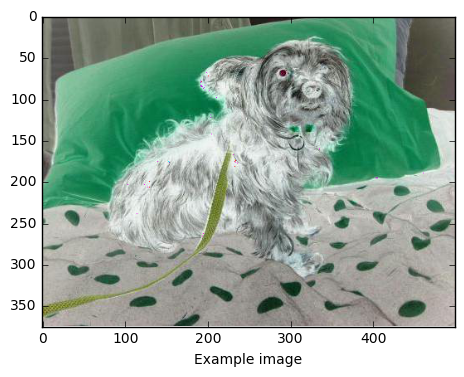

In [18]:
plt.imshow(img)
plt.xlabel('Example image')
plt.show()

In [20]:
def calc_width_height(images):
    width = []
    height = []
    for image in images:
        h, w, d = np.shape(image)
        width.append(w)
        height.append(h)
    return width,height

Mean width: 383.083333333
Mean height: 341.166666667


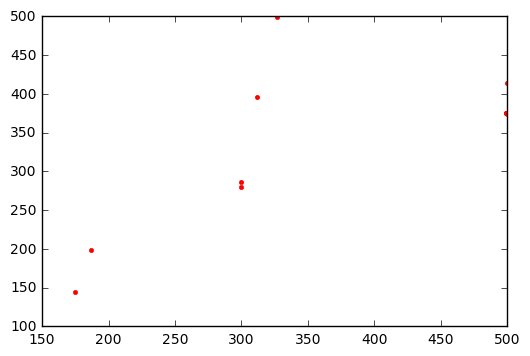

In [21]:
width,height = calc_width_height(train_x)
print('Mean width:',np.mean(width))
print('Mean height:',np.mean(height))
plt.plot(width, height, '.r')
plt.show()

In [19]:
train_x2=load_images_new(path,275,275) 
train_x2[0].shape

(250, 250, 3)

Mean width: 250.0
Mean height: 250.0


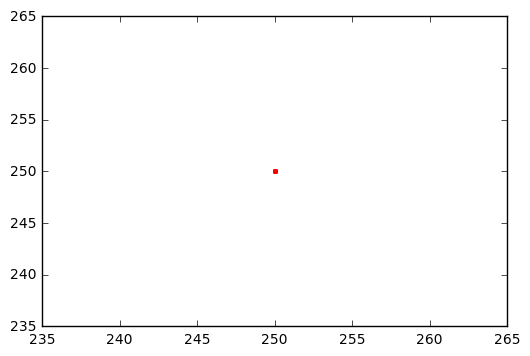

In [22]:
width,height = calc_width_height(train_x2)
print('Mean width:',np.mean(width))
print('Mean height:',np.mean(height))
plt.plot(width, height, '.r')
plt.show()

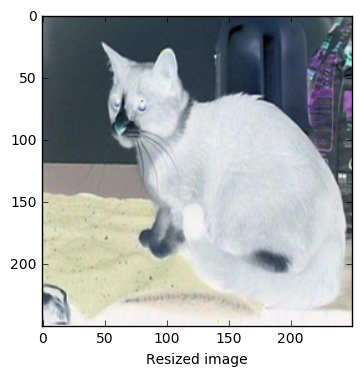

In [23]:
plt.imshow(train_x2[1])
plt.xlabel('Resized image')
plt.show()

In [13]:
train_image_file_names = [i for i in listdir(path)]
labels = [[1., 0.] if 'dog' in name else [0., 1.] for name in train_image_file_names]
train_image_file_names

['dog.0.jpg',
 'cat.4.jpg',
 'cat.1.jpg',
 'dog.5.jpg',
 'cat.5.jpg',
 'cat.3.jpg',
 'cat.0.jpg',
 'dog.3.jpg',
 'dog.2.jpg',
 'cat.2.jpg',
 'dog.4.jpg',
 'dog.1.jpg']

In [14]:
labels

[[1.0, 0.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [1.0, 0.0],
 [0.0, 1.0],
 [1.0, 0.0],
 [1.0, 0.0]]

In [42]:
def CNNlayer(input_layer,filter_size,num_filters,stride=1,use_pooling=True):
    
    input_shape=input_layer.get_shape()
    input_channels=input_shape[3]
    filter_shape=[filter_size, filter_size,input_channels,num_filters]
    w=tf.Variable(tf.random_normal(shape=filter_shape))
    b=tf.Variable(tf.constant(value=0.05,shape=[num_filters]))
    output_layer=tf.nn.conv2d(input_layer,filter=w,strides=[1,stride,stride,1],padding="SAME")+b
    if use_pooling is True:
                  output_layer=tf.nn.max_pool(value=output_layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
    return output_layer

## layer1

In [15]:
image = tf.placeholder(tf.float32, [None, 400, 400, 3])
num_kernels = 16
size_kernel = 15
shape_kernel = [size_kernel, size_kernel, 3, num_kernels]
#first layer
weights = tf.truncated_normal(shape=shape_kernel,stddev=0.5)
bias = tf.constant(value=0.05, shape=[num_kernels])
layer1 = tf.nn.conv2d(image,filter=weights,strides=[1,4,4,1],padding="SAME")
layer1+=bias
layer1 = tf.nn.max_pool(value=layer1,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')
layer1 = tf.nn.relu(layer1)

In [16]:
layer1

<tf.Tensor 'Relu:0' shape=(?, 50, 50, 16) dtype=float32>

## layer 2

In [17]:
num_kernels = 36
size_kernel = 15
shape_kernel = [size_kernel, size_kernel, 16, num_kernels]
#second layer
weights = tf.truncated_normal(shape=shape_kernel,stddev=0.5)
bias = tf.constant(value=0.05, shape=[num_kernels])
layer2 = tf.nn.conv2d(layer1,filter=weights,strides=[1,2,2,1],padding="SAME")
layer2+=bias
layer2 = tf.nn.max_pool(value=layer2,ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1],padding='SAME')
layer2 = tf.nn.relu(layer2)

In [18]:
layer2

<tf.Tensor 'Relu_1:0' shape=(?, 13, 13, 36) dtype=float32>

### now flatten before Fully connected layer

In [23]:
layer2_shape=layer2.get_shape()

In [25]:
total_features=layer2_shape[1:4]

In [26]:
total_features

TensorShape([Dimension(13), Dimension(13), Dimension(36)])

In [31]:
num_elem=total_features.num_elements() #product of dimensions

In [32]:
flat_layer=tf.reshape(layer2,[-1, num_elem ])

In [33]:
flat_layer

<tf.Tensor 'Reshape_2:0' shape=(?, 6084) dtype=float32>

## Fully connected layer

In [34]:
def create_fc_layer(input_layer,input_channels,output_channels):
    w=tf.Variable(tf.random_normal([input_channels,output_channels],mean=0,stddev=0.5))
    b=tf.Variable(tf.random_normal([1,output_channels]))
    layer=tf.matmul(input_layer,w)+b
    return layer
    

In [4]:
image_path = '/home/huzaifa/ml/cats vs dogs/small/'


In [11]:
img = Image.open(image_path+'dog.0.jpg')
img = img.resize([250,250], Image.ANTIALIAS)
img = np.array(img).astype('float32')
#img = np.expand_dims(np.asarray(img), axis = 0)

In [6]:
imageList = listdir(image_path)


In [7]:
imageList

['dog.0.jpg',
 'cat.4.jpg',
 'cat.1.jpg',
 'dog.5.jpg',
 'cat.5.jpg',
 'cat.3.jpg',
 'cat.0.jpg',
 'dog.3.jpg',
 'dog.2.jpg',
 'cat.2.jpg',
 'dog.4.jpg',
 'dog.1.jpg']

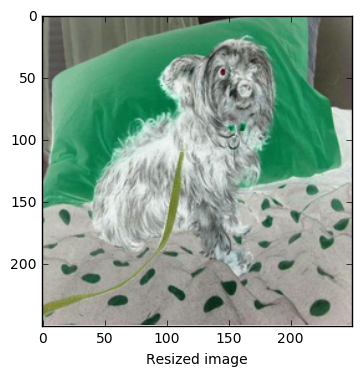

In [13]:
plt.imshow(img)
plt.xlabel('Resized image')
plt.show()

In [12]:
img.shape

(250, 250, 3)

In [34]:
label = np.array([[1.0] if 'dog' in i else [0] for i in listdir(path)])

In [35]:
label

array([[ 1.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.]])

In [36]:
label.shape

(12, 1)

In [37]:
import git_jupyter as gj

In [38]:
sess=gj.Jupyter('CNN.ipynb','**************','Machine-Learning','**************','**********')

In [ ]:
sess.update('cats vs dogs.ipynb','updated')